In [1]:
import pandas as pd
import numpy as np
import awkward0 as awkward
import uproot3_methods as uproot_methods
import matplotlib.pyplot as plt

## Open HEP datasets

### Top quark jet tagging
- https://zenodo.org/record/2603256#.YKdfqSZRVH4
- graph-level classification, regression
- ~100k jets, ~100 constituents per jet


### TrackML
- https://zenodo.org/record/4730157#.YKetjy8RoWo
- edge classification


### MLPF
- https://zenodo.org/record/4559324#.YKeuDS8RoWo
- node classification and regression
- ~50k events, ~5000 particles per event

In [2]:
#Read 10000 jets from top quark jet tagging
df = pd.read_hdf("train.h5", key="table", start=0, stop=10000)

In [3]:
df.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
375,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
377,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
378,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
379,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
380,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [4]:
#based on https://github.com/hqucms/ParticleNet/blob/master/tf-keras/convert_dataset.ipynb
def _col_list(prefix, max_particles=200):
    return ['%s_%d'%(prefix,i) for i in range(max_particles)]

def get_constituents(df):
    _px = df[_col_list('PX')].values
    _py = df[_col_list('PY')].values
    _pz = df[_col_list('PZ')].values
    _e = df[_col_list('E')].values

    mask = _e>0
    n_particles = np.sum(mask, axis=1)

    px = awkward.JaggedArray.fromcounts(n_particles, _px[mask])
    py = awkward.JaggedArray.fromcounts(n_particles, _py[mask])
    pz = awkward.JaggedArray.fromcounts(n_particles, _pz[mask])
    energy = awkward.JaggedArray.fromcounts(n_particles, _e[mask])

    p4 = uproot_methods.TLorentzVectorArray.from_cartesian(px, py, pz, energy)
    jet_p4 = p4.sum()

    eta = jet_p4.eta - p4.eta
    phi = jet_p4.delta_phi(p4)
    pt = p4.pt / jet_p4.pt
    label = df['is_signal_new'].values
    
    return pt, eta, phi, label

pt, eta, phi, label = get_constituents(df)

In [5]:
len(pt)

10000

In [6]:
pt.counts

array([23, 43, 41, ..., 36, 28, 20])

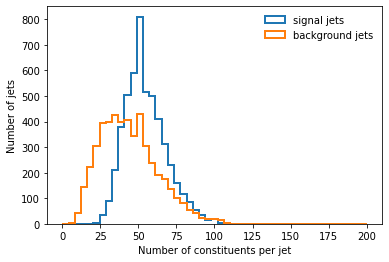

In [7]:
bins = np.linspace(0,200,50)
plt.hist(pt[label==1].counts, bins=bins, label="signal jets", histtype="step", lw=2);
plt.hist(pt[label==0].counts, bins=bins, label="background jets", histtype="step", lw=2);
plt.ylabel("Number of jets")
plt.xlabel("Number of constituents per jet")
plt.legend(frameon=False)

## Let's plot a random sample of the signal and background jet constituents.

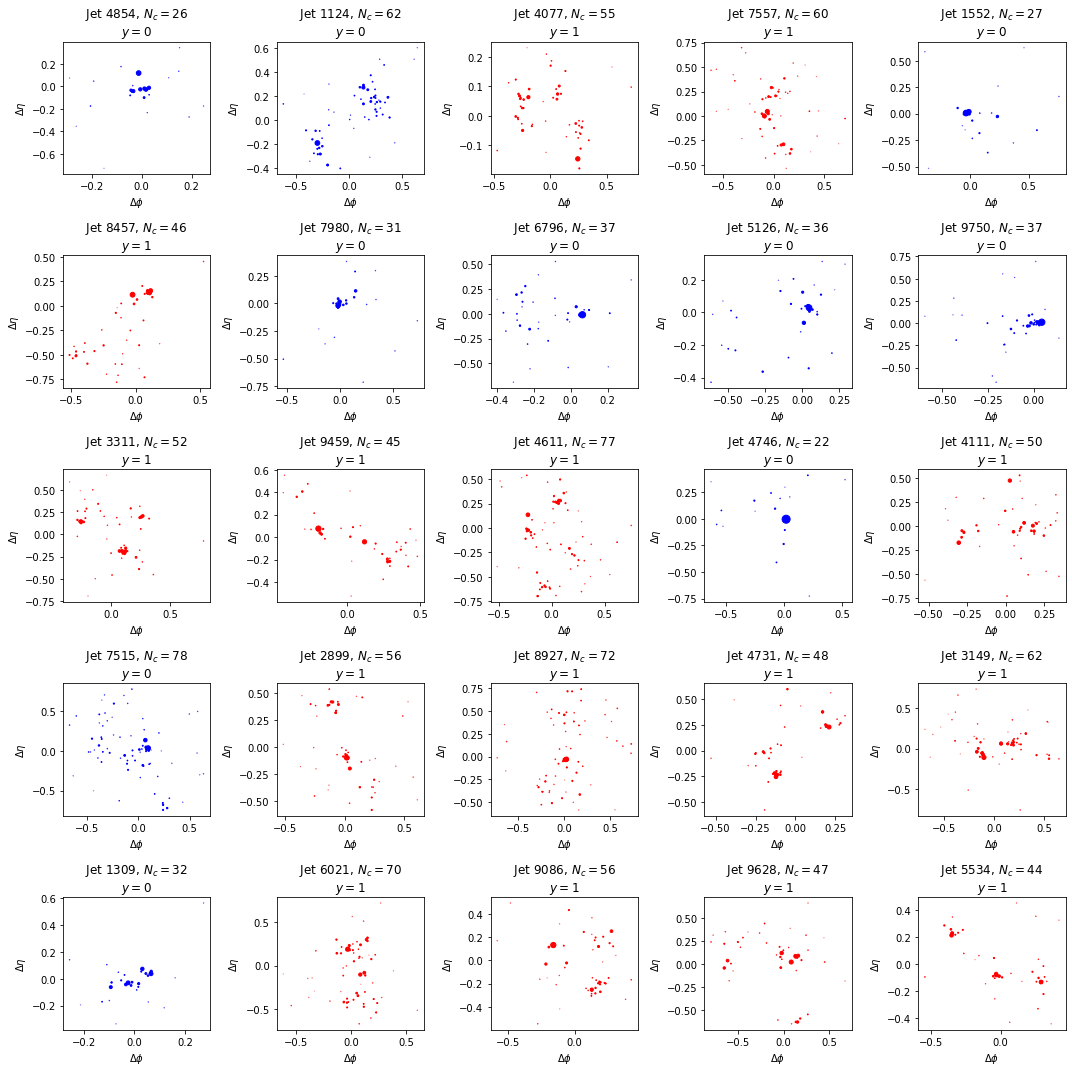

In [8]:
random_indices = np.random.permutation(len(eta))
plt.figure(figsize=(15,15))
for iplt in range(1,26):
    iptcl = random_indices[iplt]
    ax = plt.subplot(5,5,iplt)
    color = "blue"
    if label[iptcl] == 1:
        color = "red"
    ax.scatter(eta[iptcl], phi[iptcl], s=100*pt[iptcl], marker="o", color=color)
    plt.xlabel("$\Delta \phi$")
    plt.ylabel("$\Delta \eta$")
    plt.title("Jet {}, $N_c={}$\n$y={}$".format(iptcl, len(eta[iptcl]), label[iptcl]))
plt.tight_layout()

## Creating a PyTorch dataset

In [9]:
import os.path as osp

import torch
from torch_geometric.data import Data, Dataset, DataLoader

from torch_geometric.nn import knn_graph

class TopTaggingDataset(Dataset):
    def __init__(self, dataframe, knn_k=4):
        super(TopTaggingDataset, self).__init__()
        
        self.knn_k = knn_k
        pt, eta, phi, label = get_constituents(dataframe)
        
        self.pt = pt
        self.eta = eta
        self.phi = phi
        self.label = label

    def len(self):
        return len(self.pt)

    def get(self, idx):
        
        pt = torch.tensor(self.pt[idx]).to(torch.float32)
        eta = torch.tensor(self.eta[idx]).to(torch.float32)
        phi = torch.tensor(self.phi[idx]).to(torch.float32)
        
        label = torch.tensor(self.label[idx]).to(torch.float32)
        
        x = torch.stack([pt, eta, phi], axis=-1)
        
        #construct knn graph from (eta, phi) coordinates
        edge_index = knn_graph(x[:, [1,2]], k=self.knn_k)
        
        data = Data(
            x = x,
            y = label,
            edge_index = edge_index
        )
        
        return data

In [10]:
dataset = TopTaggingDataset(df, knn_k=4)

for i in range(10):
    data = dataset.get(i)
    print(data.x.shape, data.edge_index.shape, data.y)

torch.Size([23, 3]) torch.Size([2, 92]) tensor(0.)
torch.Size([43, 3]) torch.Size([2, 172]) tensor(0.)
torch.Size([41, 3]) torch.Size([2, 164]) tensor(0.)
torch.Size([25, 3]) torch.Size([2, 100]) tensor(0.)
torch.Size([73, 3]) torch.Size([2, 292]) tensor(0.)
torch.Size([55, 3]) torch.Size([2, 220]) tensor(0.)
torch.Size([53, 3]) torch.Size([2, 212]) tensor(0.)
torch.Size([70, 3]) torch.Size([2, 280]) tensor(0.)
torch.Size([27, 3]) torch.Size([2, 108]) tensor(0.)
torch.Size([64, 3]) torch.Size([2, 256]) tensor(0.)


Text(0.5, 0, '$\\Delta \\phi$')

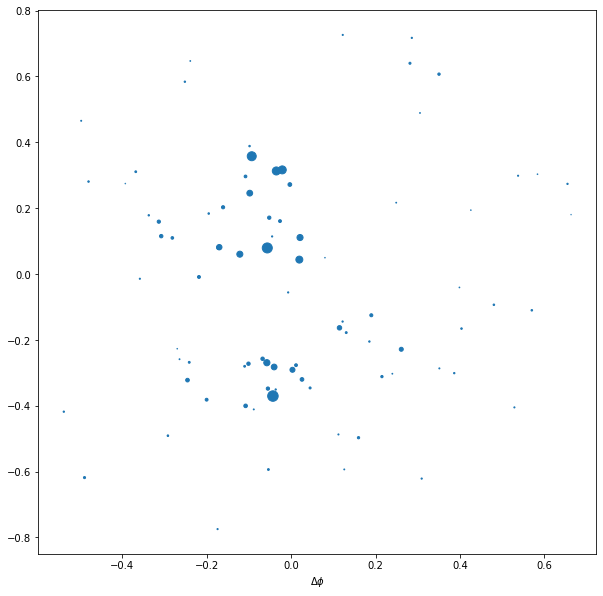

In [11]:
ijet = 10
data = dataset.get(ijet)
    
plt.figure(figsize=(10, 10))
plt.scatter(data.x[:, 1], data.x[:, 2], s=1000*data.x[:, 0]);
plt.xlabel("$\Delta \eta$")
plt.xlabel("$\Delta \phi$")

Text(0.5, 1.0, 'Graph adjacency matrix')

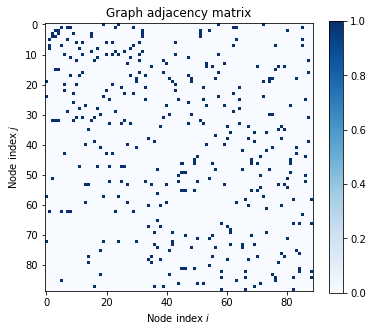

In [12]:
from torch_geometric.utils import to_dense_adj
dense_adj = to_dense_adj(data.edge_index)

plt.figure(figsize=(6,5))
plt.imshow(dense_adj[0], interpolation="none", cmap="Blues")
plt.colorbar()
plt.xlabel("Node index $i$")
plt.ylabel("Node index $j$")
plt.title("Graph adjacency matrix")

In [13]:
from torch_geometric.utils import to_networkx
import networkx as nx

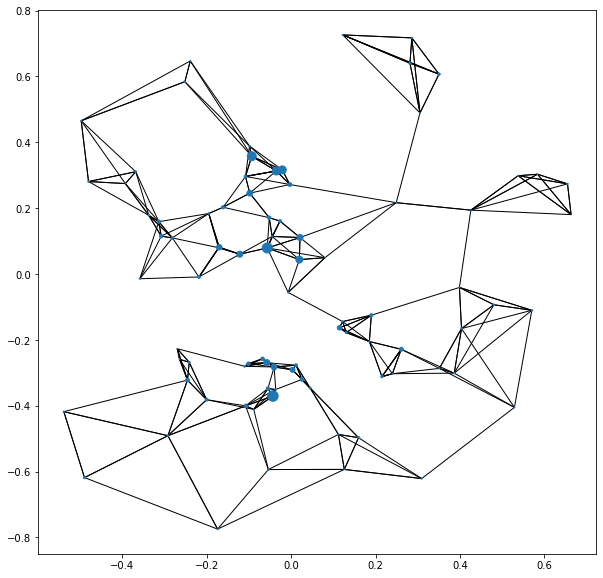

In [14]:
nxg = to_networkx(data)
pos = {i: (data.x[i, 1], data.x[i, 2]) for i in nxg.nodes}

plt.figure(figsize=(10, 10))
ax = plt.axes()
nx.draw_networkx(nxg, pos, with_labels=False, arrows=False, node_size=1000*data.x[:, 0], node_shape="o", ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## Batching the data

In [15]:
loader = DataLoader(dataset, batch_size=10, shuffle=True)

ibatch = 0
for data_batched in loader:
    print(ibatch, data_batched.x.shape, data_batched.y)
    ibatch += 1
    if ibatch>5:
        break

0 torch.Size([421, 3]) tensor([0., 0., 1., 1., 1., 0., 1., 1., 0., 1.])
1 torch.Size([504, 3]) tensor([1., 1., 1., 0., 1., 0., 1., 1., 0., 1.])
2 torch.Size([505, 3]) tensor([0., 1., 1., 0., 1., 0., 0., 0., 0., 1.])
3 torch.Size([427, 3]) tensor([1., 0., 0., 1., 0., 1., 0., 1., 1., 0.])
4 torch.Size([530, 3]) tensor([0., 1., 1., 0., 0., 0., 1., 0., 1., 0.])
5 torch.Size([460, 3]) tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 1.])


Text(0.5, 1.0, 'Graph adjacency matrix')

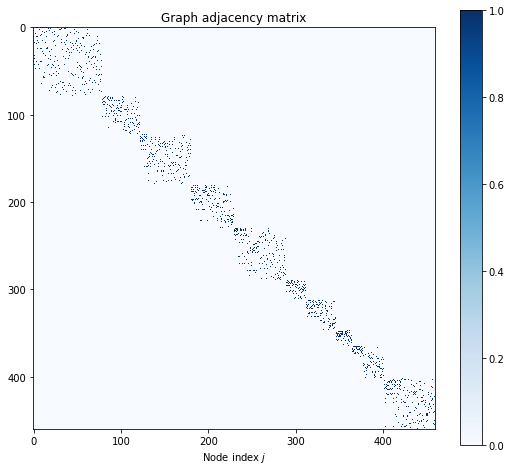

In [16]:
dense_adj = to_dense_adj(data_batched.edge_index)

plt.figure(figsize=(9,8))
plt.imshow(dense_adj[0], interpolation="none", cmap="Blues")
plt.colorbar()
plt.xlabel("Node index $i$")
plt.xlabel("Node index $j$")
plt.title("Graph adjacency matrix")

In [17]:
data_batched.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

## Training a very simple GCN

In [18]:
from torch_geometric.nn import GCNConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self, num_node_features=3):
        super(Net, self).__init__()
        
        #(3 -> 32)
        self.conv1 = GCNConv(num_node_features, 32)
        
        #(32 -> 1)
        self.output = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        #add a batch index, in in case we are running on a single graph
        if not hasattr(data, "batch"):
            data.batch = torch.zeros(len(x), dtype=torch.int64).to(x.device)
        
        #Transform the nodes with the graph convolution
        transformed_nodes = self.conv1(x, edge_index)
        transformed_nodes = torch.nn.functional.elu(transformed_nodes)
        
        #Sum up all the node vectors in each graph according to the batch index
        per_graph_aggregation = global_add_pool(transformed_nodes, data.batch)
        
        #For each graph,
        #predict the classification output based on the total vector
        #from the previous aggregation step
        output = self.output(per_graph_aggregation)
        return torch.sigmoid(output)


In [19]:
net = Net()

In [20]:
net(data_batched)

tensor([[0.5549],
        [0.4795],
        [0.5111],
        [0.4461],
        [0.4069],
        [0.4821],
        [0.4921],
        [0.5115],
        [0.4939],
        [0.5389]], grad_fn=<SigmoidBackward>)

In [21]:
net.conv1.weight.shape, net.conv1.bias.shape

(torch.Size([3, 32]), torch.Size([32]))

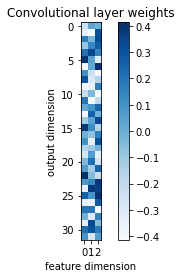

In [22]:
plt.title("Convolutional layer weights")
plt.imshow(net.conv1.weight.detach().numpy().T, cmap="Blues")
plt.xlabel("feature dimension")
plt.ylabel("output dimension")
plt.xticks([0,1,2])
plt.colorbar()

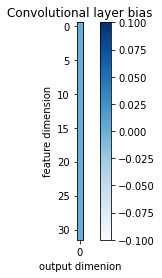

In [23]:
plt.title("Convolutional layer bias")
plt.imshow(net.conv1.bias.unsqueeze(-1).detach().numpy(), cmap="Blues")
plt.xlabel("output dimenion")
plt.ylabel("feature dimension")
plt.xticks([0])
plt.colorbar()

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
losses_train = []

for epoch in range(20):
    
    loss_train_epoch = []
    
    for data_batch in loader:
        data_batch = data_batch.to(device)
        
        optimizer.zero_grad()
        out = model(data_batch)
        loss = torch.nn.functional.binary_cross_entropy(out[:, 0], data_batch.y)
        
        loss.backward()
        loss_train_epoch.append(loss.item())
        optimizer.step()
        
    loss_train_epoch = np.mean(loss_train_epoch)
    losses_train.append(loss_train_epoch)
    print(epoch, loss_train_epoch)

0 0.6598663435578346
1 0.6409706556797028
2 0.635180360108614
3 0.6310161257386208
4 0.6249564448595047
5 0.6205391810834407
6 0.6176200254559517
7 0.6142527349591255
8 0.6112599777877331
9 0.608530874490738
10 0.6065401664972305
11 0.6067167019546031
12 0.6054940590560436
13 0.6068780281245708
14 0.604010203063488
15 0.6041538299322128
16 0.6035118193030358
17 0.603307550251484
18 0.602629450827837
19 0.6029621749520302


Text(0.5, 0, 'epoch')

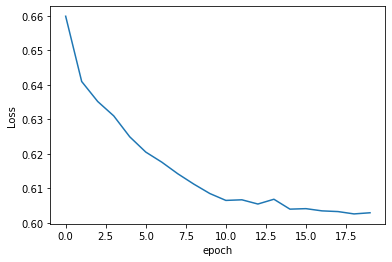

In [25]:
plt.plot(losses_train, label="training")
plt.ylabel("Loss")
plt.xlabel("epoch")

In [26]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

161

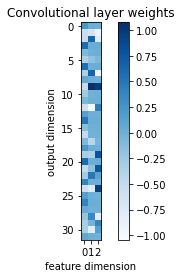

In [27]:
plt.title("Convolutional layer weights")
plt.imshow(model.conv1.weight.detach().cpu().numpy().T, cmap="Blues")
plt.xlabel("feature dimension")
plt.ylabel("output dimension")
plt.xticks([0,1,2])
plt.colorbar()

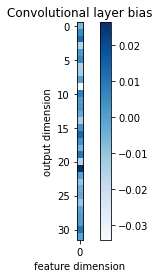

In [28]:
plt.title("Convolutional layer bias")
plt.imshow(model.conv1.bias.unsqueeze(-1).detach().cpu().numpy(), cmap="Blues")
plt.xlabel("feature dimension")
plt.ylabel("output dimension")
plt.xticks([0])
plt.colorbar()

In [29]:
data = dataset.get(ijet).to(device)
embedded_nodes = model.conv1(data.x, data.edge_index)

In [30]:
data.x.shape, embedded_nodes.shape

(torch.Size([89, 3]), torch.Size([89, 32]))

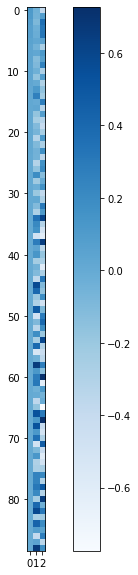

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(data.x.cpu().numpy(), interpolation="none", cmap="Blues")
plt.colorbar()
plt.xticks([0,1,2]);

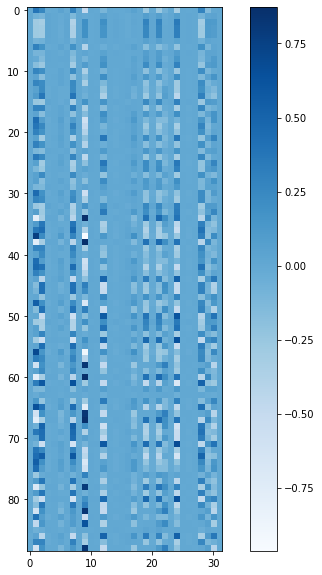

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(embedded_nodes.detach().cpu().numpy(), interpolation="none", cmap="Blues")
plt.colorbar()

In [33]:
model_cpu = model.to('cpu')

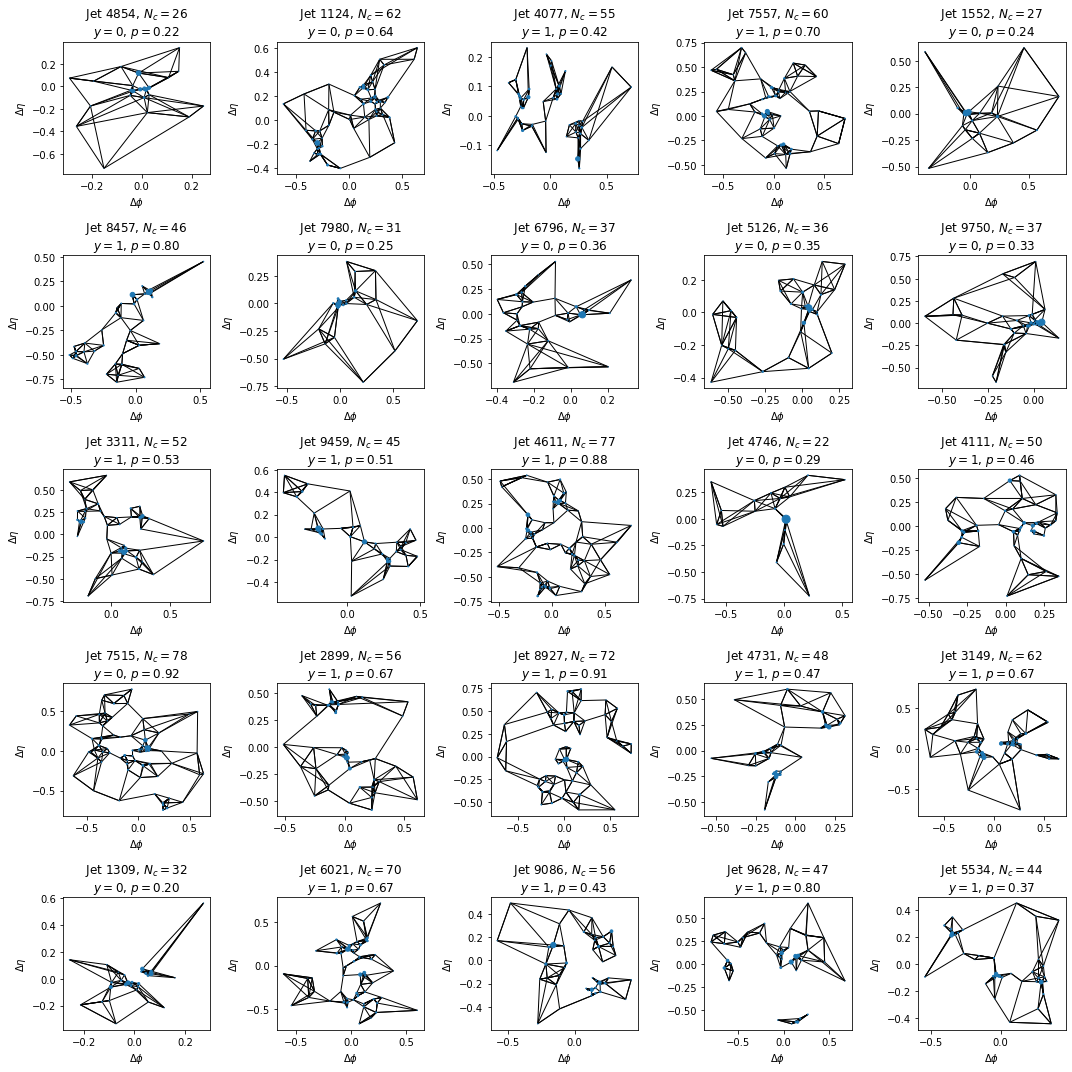

In [34]:
plt.figure(figsize=(15,15))
for iplt in range(1,26):
    iptcl = random_indices[iplt]
    ax = plt.subplot(5,5,iplt)
    data = dataset.get(iptcl)
    
    pred = model_cpu(data).detach()[0,0].item()
    
    color = "blue"
    if data.y == 1:
        color = "red"
    
    nxg = to_networkx(data)
    pos = {i: (data.x[i, 1], data.x[i, 2]) for i in nxg.nodes}

    nx.draw_networkx(
        nxg, pos,
        with_labels=False,
        arrows=False,
        node_size=100*data.x[:, 0],
        node_shape="o",
        ax=ax
    )
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    plt.xlabel("$\Delta \phi$")
    plt.ylabel("$\Delta \eta$")
    plt.title("Jet {}, $N_c={}$\n$y={}$, $p={:.2f}$".format(iptcl, len(eta[iptcl]), label[iptcl], pred))
plt.tight_layout()

## Dynamic graph network

In [35]:
class DynamicNet(torch.nn.Module):
    def __init__(self, knn_k=4, num_node_features=3):
        super(DynamicNet, self).__init__()
        
        self.knn_k = knn_k
        
        #(3 -> 32)
        self.lin1 = torch.nn.Linear(num_node_features, 32)
        
        #(32 -> 32)
        self.conv1 = GCNConv(32, 32)
            
        #(32 -> 1)
        self.output = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        #add a batch index, in in case we are running on a single graph
        if not hasattr(data, "batch"):
            data.batch = torch.zeros(len(x), dtype=torch.int64).to(x.device)
        
        x = self.lin1(x)
        
        edge_index2 = knn_graph(x, k=self.knn_k, batch=data.batch)
        x = self.conv1(x, edge_index2)
        xg = global_add_pool(x, data.batch)
        output = self.output(xg)
        
        return torch.sigmoid(output), edge_index2


In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net2 = DynamicNet().to(device)

optimizer = torch.optim.Adam(net2.parameters(), lr=1e-3)

model.train()
losses_train = []

for epoch in range(20):
    
    loss_train_epoch = []
    
    for data_batch in loader:
        data_batch = data_batch.to(device)
        
        optimizer.zero_grad()
        out, _ = net2(data_batch)
        loss = torch.nn.functional.binary_cross_entropy(out[:, 0], data_batch.y)
        
        loss.backward()
        loss_train_epoch.append(loss.item())
        optimizer.step()
        
    loss_train_epoch = np.mean(loss_train_epoch)
    losses_train.append(loss_train_epoch)
    print(epoch, loss_train_epoch)

0 0.7240782676339149
1 0.7066716344356537
2 0.691054485887289
3 0.684078375607729
4 0.6761437393426896
5 0.6690462546348572
6 0.6595879821777344
7 0.6582403957843781
8 0.6566011932790279
9 0.6512194511592388
10 0.6499822781682014
11 0.6488707108199596
12 0.6489063706398011
13 0.6473194464147091
14 0.6478797287940979
15 0.6463579959869384
16 0.6463885635435581
17 0.647404534816742
18 0.6457780322134494
19 0.6457460168898106


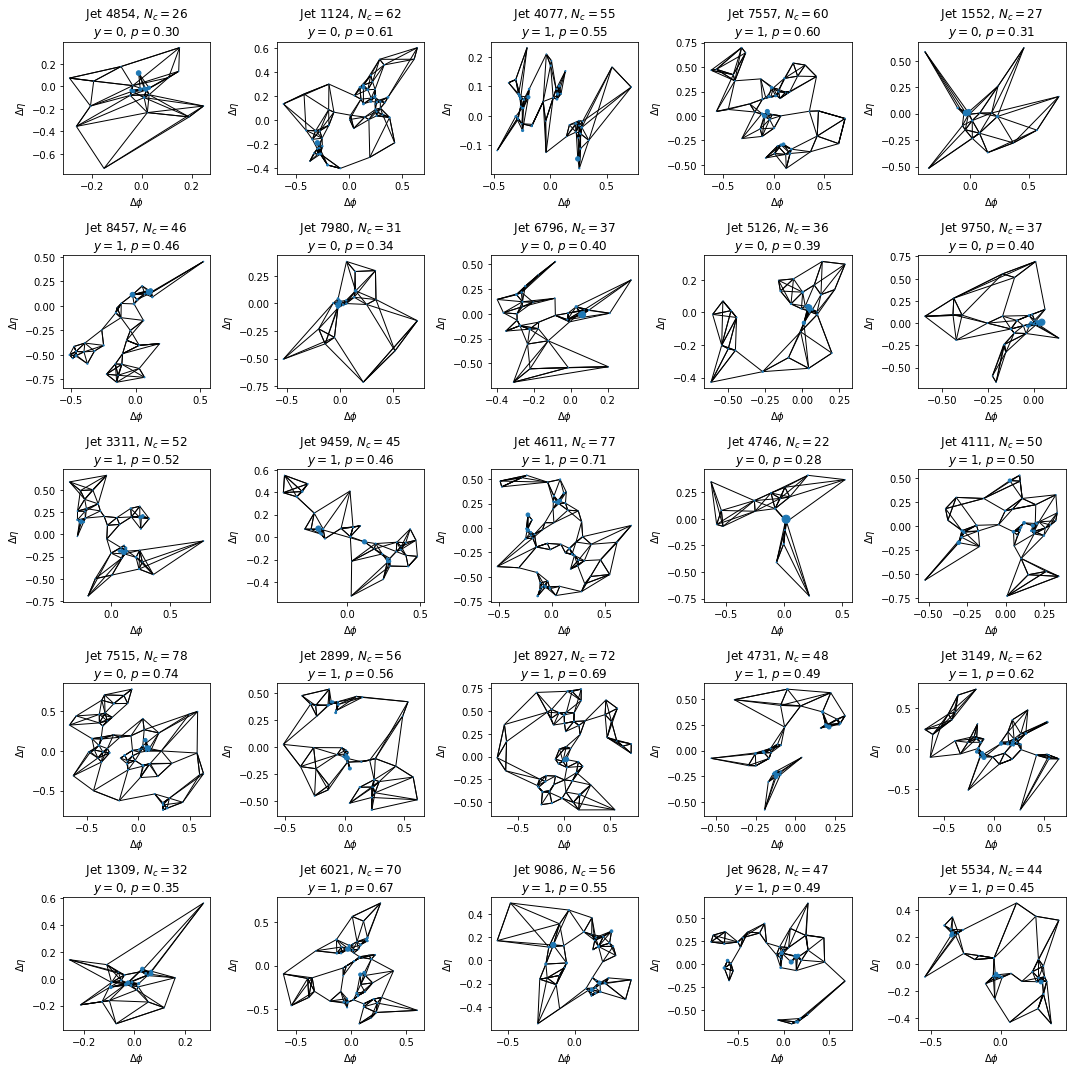

In [37]:
net2_cpu = net2.cpu()

plt.figure(figsize=(15,15))
for iplt in range(1,26):
    iptcl = random_indices[iplt]
    ax = plt.subplot(5,5,iplt)
    data = dataset.get(iptcl)
    
    pred, edge_index = net2_cpu(data)
    pred = pred.detach().item()
    
    data.edge_index = edge_index
    
    color = "blue"
    if data.y == 1:
        color = "red"
    
    nxg = to_networkx(data)
    pos = {i: (data.x[i, 1], data.x[i, 2]) for i in nxg.nodes}

    nx.draw_networkx(
        nxg, pos,
        with_labels=False,
        arrows=False,
        node_size=100*data.x[:, 0],
        node_shape="o",
        ax=ax
    )
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    plt.xlabel("$\Delta \phi$")
    plt.ylabel("$\Delta \eta$")
    plt.title("Jet {}, $N_c={}$\n$y={}$, $p={:.2f}$".format(iptcl, len(eta[iptcl]), label[iptcl], pred))
plt.tight_layout()